# Guitar Classifier (powered by TensorFlow)
#### Based on https://www.tensorflow.org/tutorials/images/classification

## 1. Load Dataset

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

In [3]:
# Load Dataset
import pathlib
data_dir = pathlib.Path('images')

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

8500


Here's a Les Paul


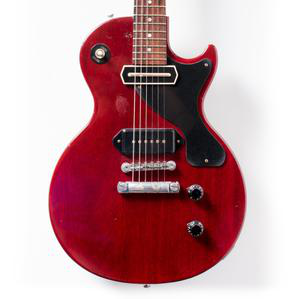

In [4]:
print("Here's a Les Paul")
les_pauls = list(data_dir.glob('gibson_les_paul/*'))
PIL.Image.open(str(les_pauls[0]))

Here's a Strat


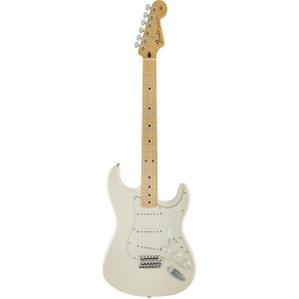

In [5]:
print ("Here's a Strat")
strats = list(data_dir.glob('fender_stratocaster/*'))
PIL.Image.open(str(strats[0]))

## 2. Split Dataset

In [6]:
# Split Dataset (Training (70%) / Test (30%))
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8500 files belonging to 11 classes.
Using 6800 files for training.
Found 8500 files belonging to 11 classes.
Using 1700 files for validation.


['fender_jaguar', 'fender_jazzmaster', 'fender_mustang', 'fender_stratocaster', 'fender_telecaster', 'gibson_ES', 'gibson_Flying_V', 'gibson_SG', 'gibson_explorer', 'gibson_firebird', 'gibson_les_paul']


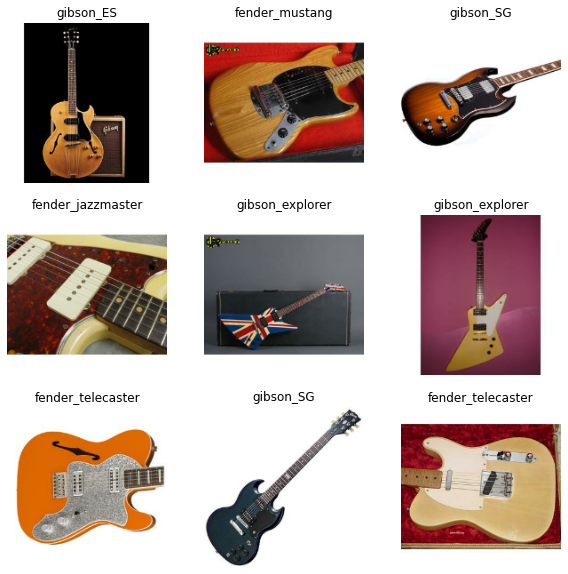

In [7]:
# Visualize the data
import matplotlib.pyplot as plt

class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## 3. Data Preprocessing

In [8]:
# Performance tuning/configurations
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
# Normalize data (between [0,1], important for neural network performance)
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Now the values are in the [0,1] interval
print(np.min(first_image), np.max(first_image))

0.0 1.0


## 4. Model Creation

In [10]:
num_classes = 11

# The model consists of three convolution blocks with a max pool layer in each of them. 
# There's a fully connected layer with 128 units on top of it that is activated by a relu activation function
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [11]:
# Model Compilation
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## 5. Model Training 

In [36]:
# Model Training 
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
213/213 [==============================] - 85s 396ms/step - loss: 2.1777 - accuracy: 0.2432 - val_loss: 1.7131 - val_accuracy: 0.4271
Epoch 2/10
213/213 [==============================] - 78s 366ms/step - loss: 1.3762 - accuracy: 0.5522 - val_loss: 1.3745 - val_accuracy: 0.5624
Epoch 3/10
213/213 [==============================] - 77s 362ms/step - loss: 0.8173 - accuracy: 0.7328 - val_loss: 1.2147 - val_accuracy: 0.6365
Epoch 4/10
213/213 [==============================] - 77s 359ms/step - loss: 0.4286 - accuracy: 0.8624 - val_loss: 1.3669 - val_accuracy: 0.6588
Epoch 5/10
213/213 [==============================] - 99s 463ms/step - loss: 0.1844 - accuracy: 0.9435 - val_loss: 1.7875 - val_accuracy: 0.6659
Epoch 6/10
213/213 [==============================] - 93s 435ms/step - loss: 0.0848 - accuracy: 0.9766 - val_loss: 1.8049 - val_accuracy: 0.6694
Epoch 7/10
213/213 [==============================] - 88s 411ms/step - loss: 0.0493 - accuracy: 0.9893 - val_loss: 2.0075 - val_ac

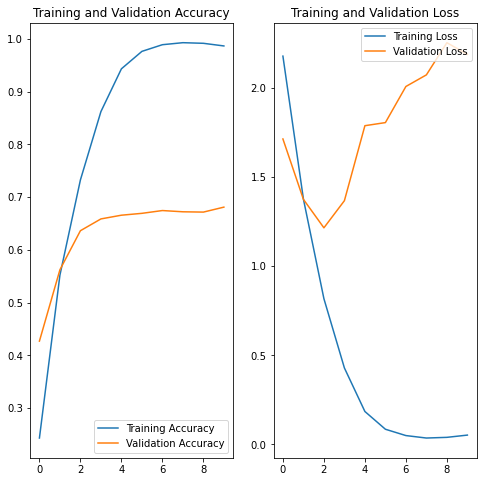

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# As we can see, the performance isn't great, in fact, the model seems to be overfitting the data
# Let's see what we can do to fix that

## 6. Data Augmentation and Model Optimization

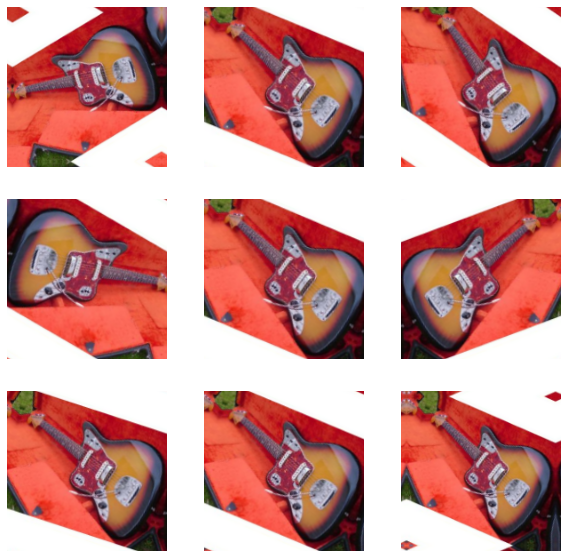

In [13]:
# Data Augmentation
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

# Visualization of the changes
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
    
# As we can see, the data is now more rich and varied, which should result in a more generalized model

In [14]:
num_classes = 11

# Include Dropout in the model
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

## 7. Model Training (Version 2)

In [ ]:
# Train the model again
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
213/213 [==============================] - 85s 397ms/step - loss: 2.3446 - accuracy: 0.1507 - val_loss: 2.2272 - val_accuracy: 0.2106
Epoch 2/30
213/213 [==============================] - 85s 397ms/step - loss: 2.2170 - accuracy: 0.2231 - val_loss: 2.1262 - val_accuracy: 0.2812
Epoch 3/30
213/213 [==============================] - 84s 394ms/step - loss: 2.0407 - accuracy: 0.2941 - val_loss: 2.0115 - val_accuracy: 0.3041
Epoch 4/30
213/213 [==============================] - 86s 406ms/step - loss: 1.8427 - accuracy: 0.3660 - val_loss: 1.8145 - val_accuracy: 0.3765
Epoch 5/30
213/213 [==============================] - 96s 450ms/step - loss: 1.7013 - accuracy: 0.4162 - val_loss: 1.6863 - val_accuracy: 0.4418
Epoch 6/30
213/213 [==============================] - 88s 413ms/step - loss: 1.5892 - accuracy: 0.4543 - val_loss: 1.6015 - val_accuracy: 0.4541
Epoch 7/30
213/213 [==============================] - 89s 417ms/step - loss: 1.4828 - accuracy: 0.4981 - val_loss: 1.5191 - val_ac

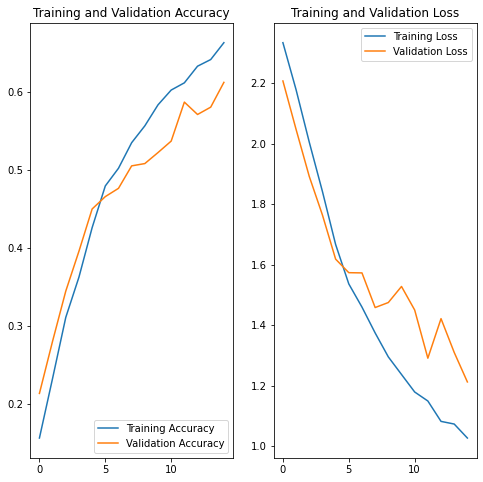

In [46]:
# Visualize the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# As we can see, the performance increase is significant. 
# The model is now more generalized and should provide a good performance in most real case scenarios

## 8. Predict on new data

In [25]:
guitar_url = "https://cdn.mos.cms.futurecdn.net/505d6b03064e460e3ee143370fe68b29-1200-80.jpg"

from IPython.display import Image
from IPython.core.display import HTML 
Image(url=guitar_url)

In [26]:
guitar_path = tf.keras.utils.get_file('lp', origin=guitar_url)

img = keras.preprocessing.image.load_img(
    guitar_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

In [27]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to gibson_les_paul with a 706.74 percent confidence.


## 9. Persist the model

In [6]:
# Standard persistence
#model.save('guitar_model')
model.save('guitar_model.h5') # H5 format

In [15]:
# Tensorflow.js persistence
#!tensorflowjs_converter --input_format=keras guitar_model.h5 guitar_model_web
!tensorflowjs_converter --input_format keras --output_format=tfjs_graph_model guitar_model.h5 guitar_model_web

2021-07-01 18:30:42.963910: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-01 18:30:43.941027: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2021-07-01 18:30:45.446365: I tensorflow/core/grappler/devices.cc:78] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2021-07-01 18:30:45.446443: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-07-01 18:30:45.451282: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1144] Optimization results for grappler item: graph_to_optimize
  function_optimize